# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [8]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

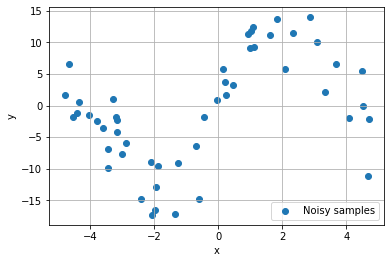

In [9]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

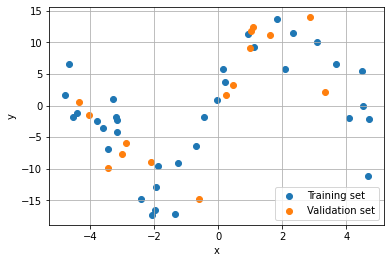

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [8]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [11]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

In [81]:
y

array([ -9.05957818,  -0.09034969,  11.50001273,   9.11022734,
        -9.85551374,  -6.81897956,  -1.10771616,   6.5817456 ,
        11.87120326,   5.83708039,   1.67461593,  -2.14124891,
         2.12299659,  -5.92544858,  -1.83803375,  -2.36319095,
       -16.53330524,   1.70871176,  -6.32825039,  -8.9667294 ,
         9.31494651,  -3.48222266, -17.32081894, -17.18409407,
        -1.8815588 ,  13.98640167,  -7.67346215,   5.71746212,
        11.27589865,  -1.80751907,  12.39451383,   1.0883081 ,
         0.50642322,   5.48508317, -11.1506254 ,  10.03142993,
       -12.83476672,  -1.52446561,  13.68530977, -14.78105811,
        -2.48182149,   0.84986647,   6.58351686,  -2.03019037,
       -14.72254274,  11.22860994,  -9.62110024,   3.70972424,
         3.31817808,  -4.15121484])

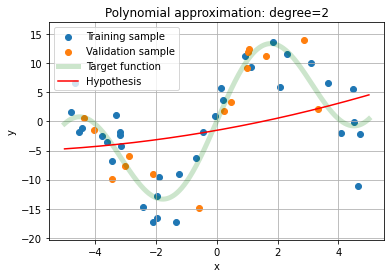

In [12]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

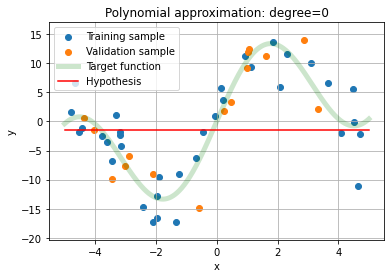

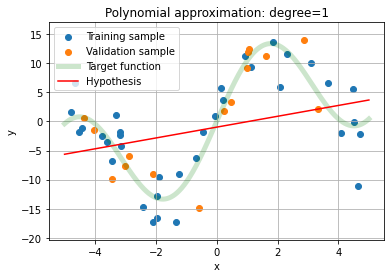

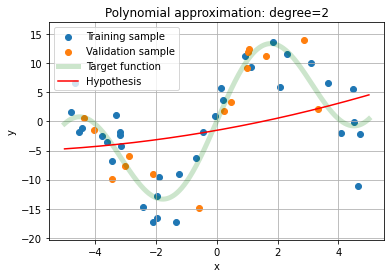

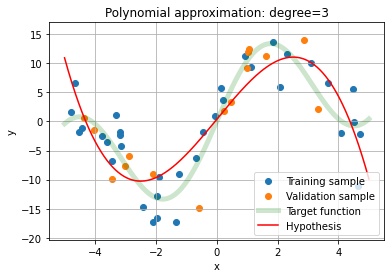

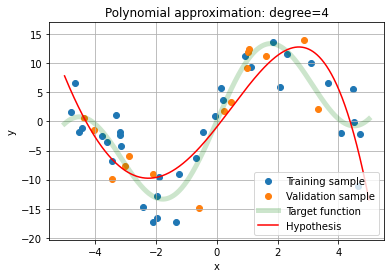

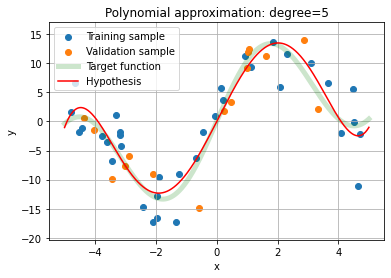

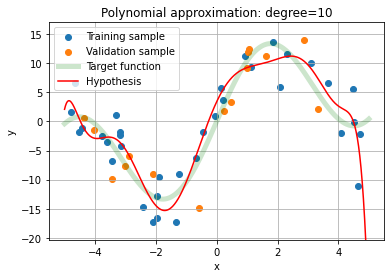

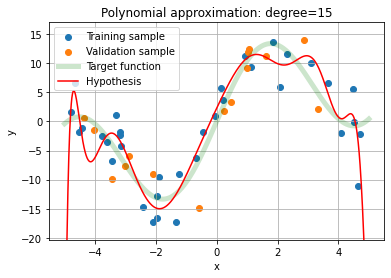

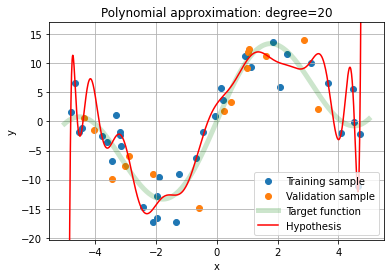

In [13]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

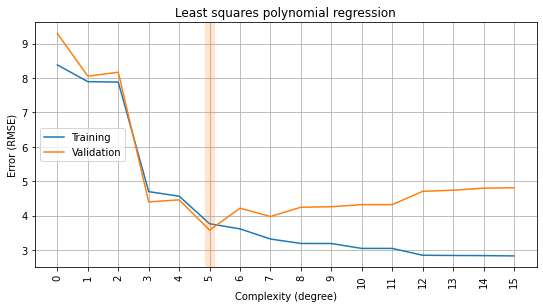

In [14]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [87]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

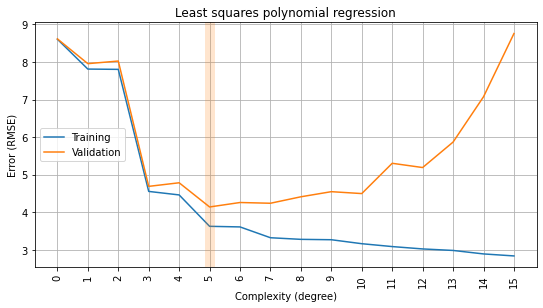

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, 
                             cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=0).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([0.]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

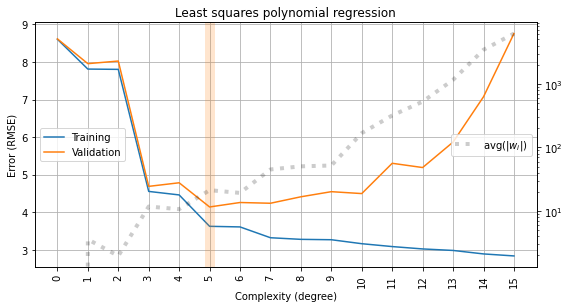

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

In [455]:
pd.DataFrame(cross_validate(make_model(0),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error'))

,fit_time,score_time,estimator,test_score,train_score
0,0.002878,0.001901,"(PolynomialFeatures(degree=0), StandardScaler(...",-8.510090,-8.681823
1,0.002323,0.001054,"(PolynomialFeatures(degree=0), StandardScaler(...",-6.793315,-9.069222
2,0.001803,0.000737,"(PolynomialFeatures(degree=0), StandardScaler(...",-10.525798,-8.081168
3,0.001752,0.000706,"(PolynomialFeatures(degree=0), StandardScaler(...",-9.984274,-8.255412
4,0.001766,0.000650,"(PolynomialFeatures(degree=0), StandardScaler(...",-7.255595,-8.935253


### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

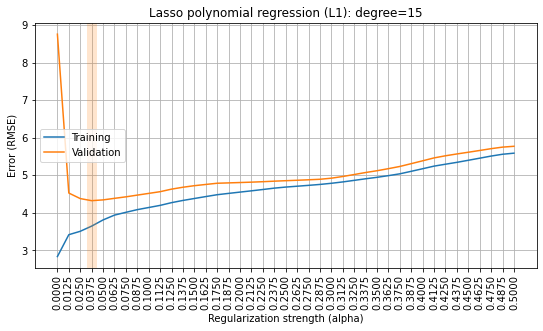

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

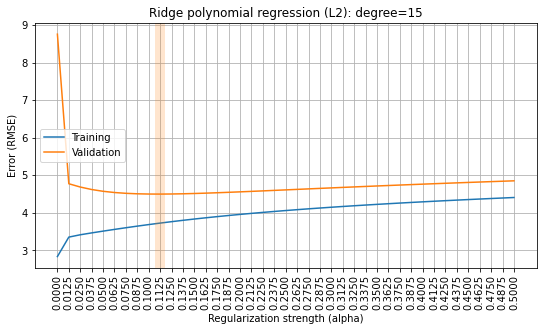

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [18]:
X_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [110]:
X_diabetes.isna().sum()

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

In [233]:
X_diabetes.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,3.777301e-16,-3.830854e-16,-3.412882e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


### Посмотрим как связаны признаки друг с другом и c целевой переменной

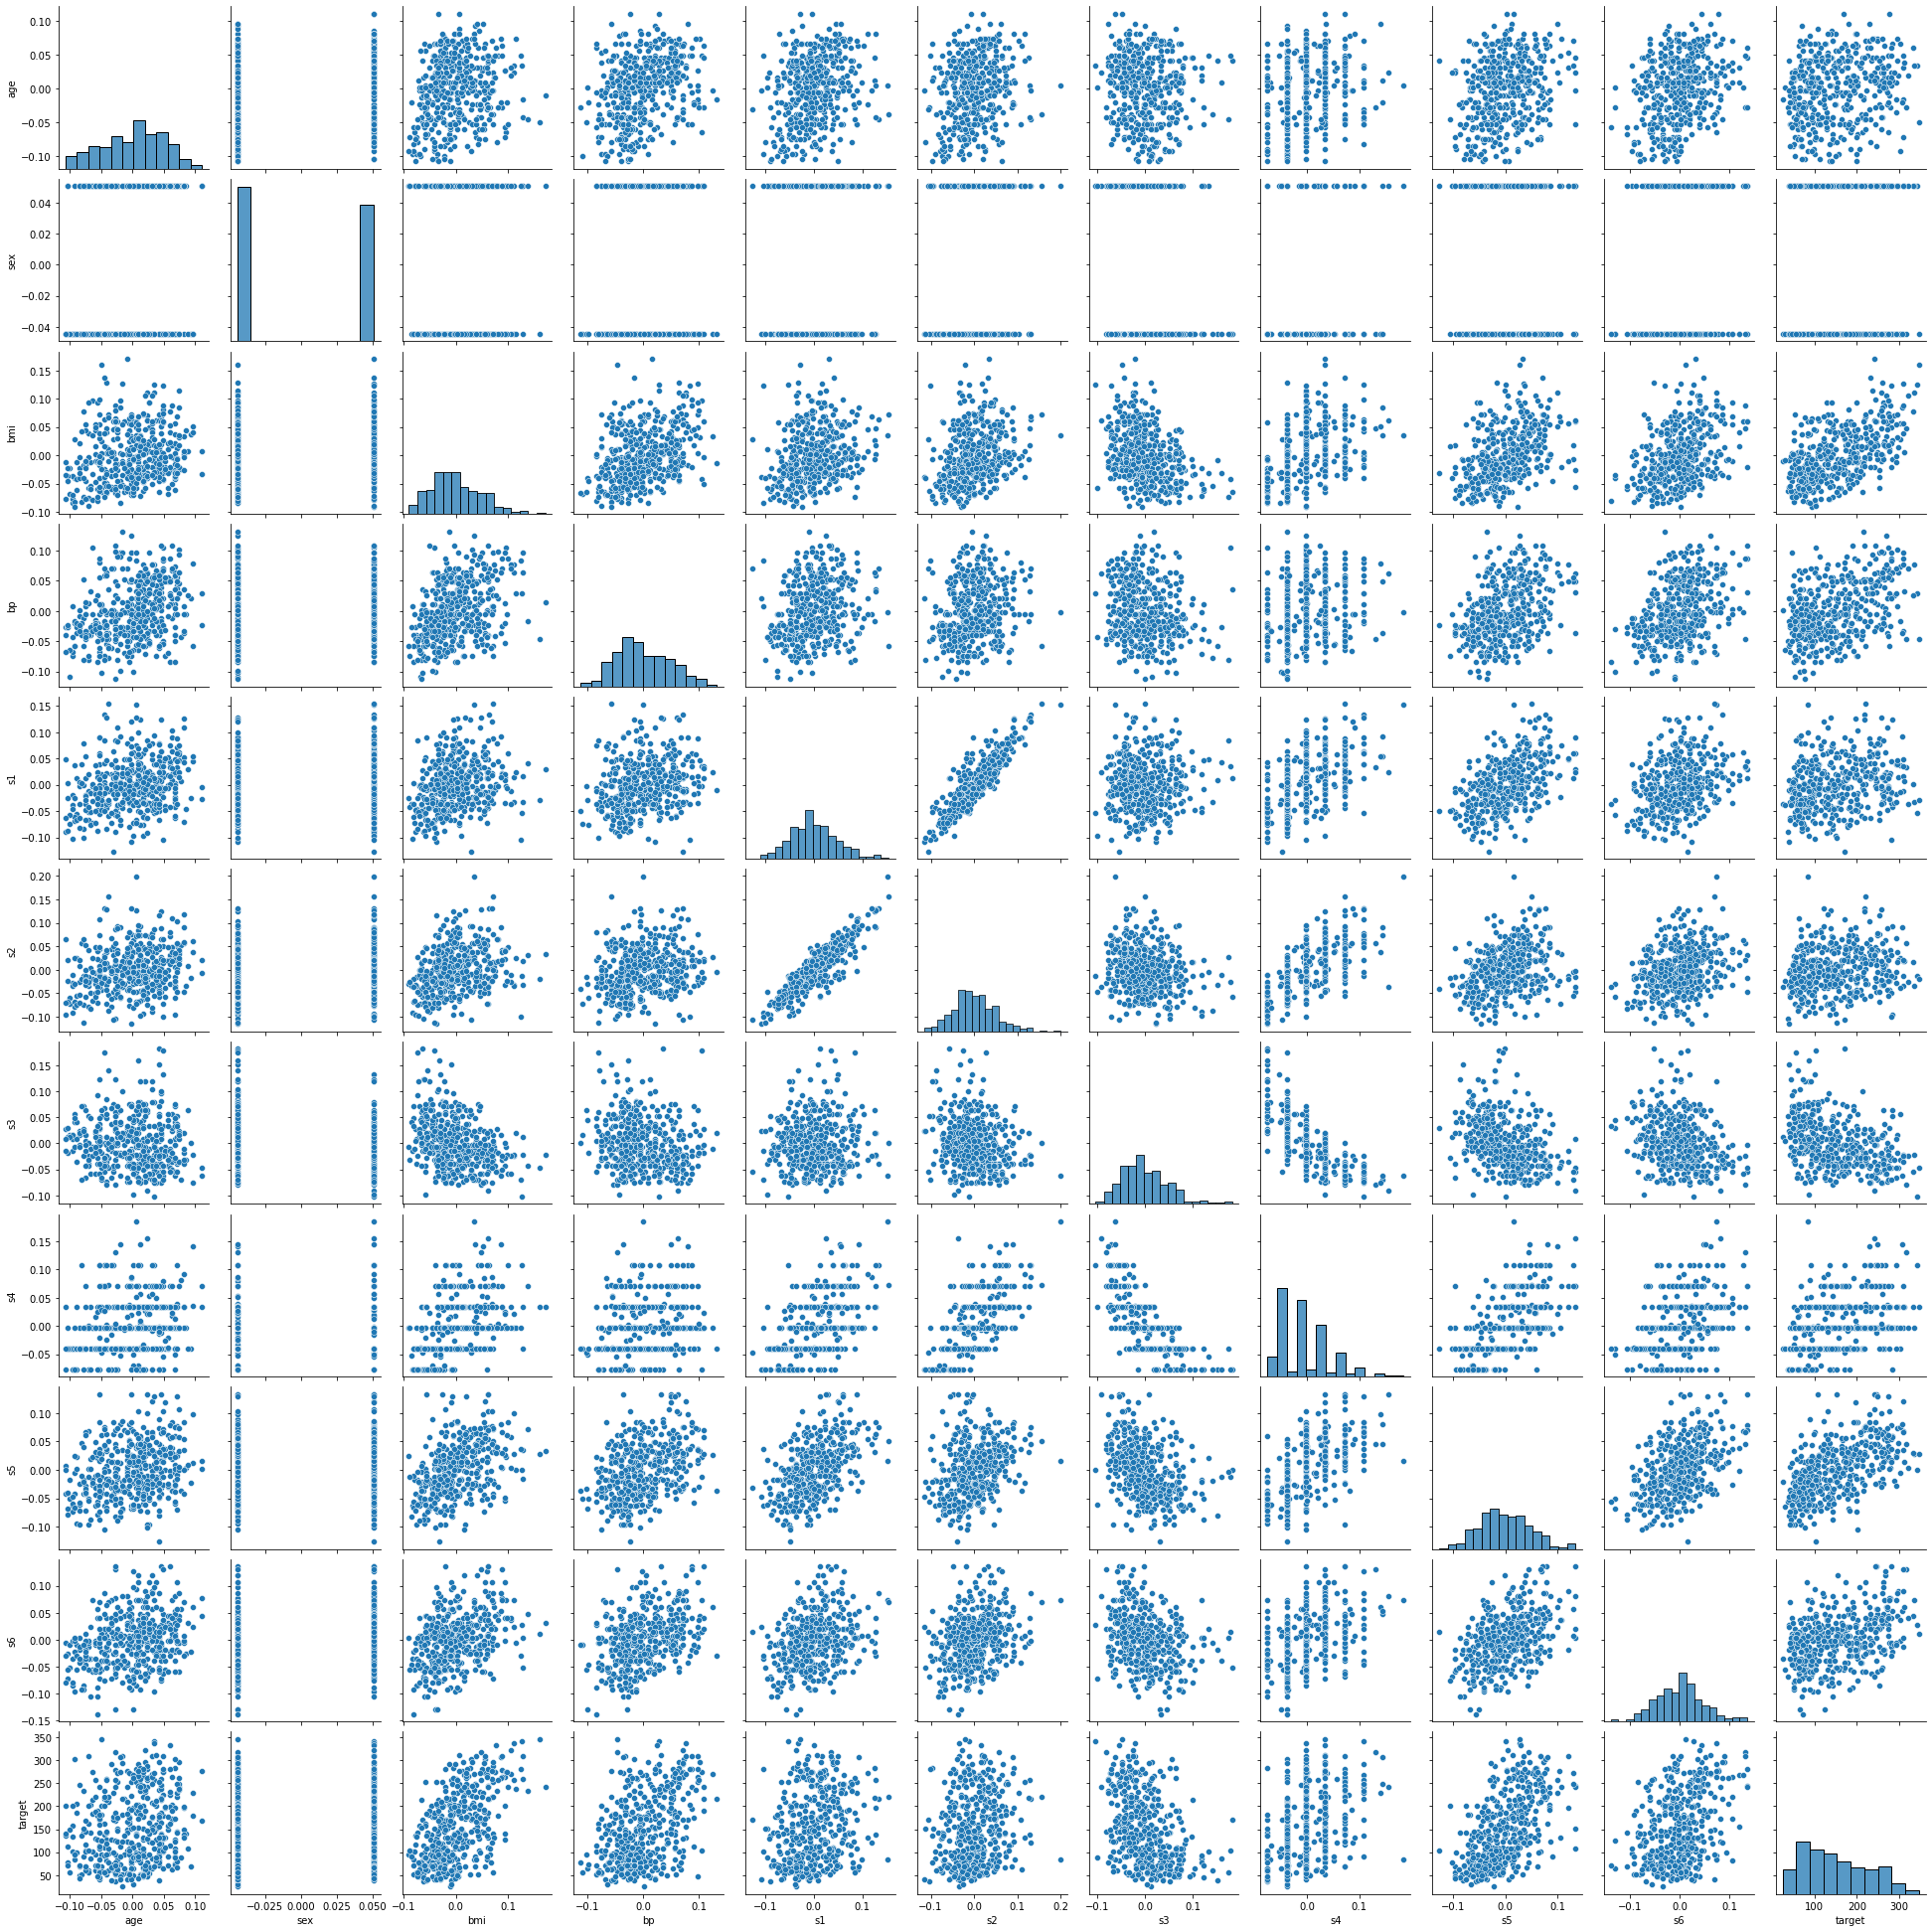

In [491]:
sns.pairplot(pd.concat((X_diabetes,y_diabetes),axis=1))

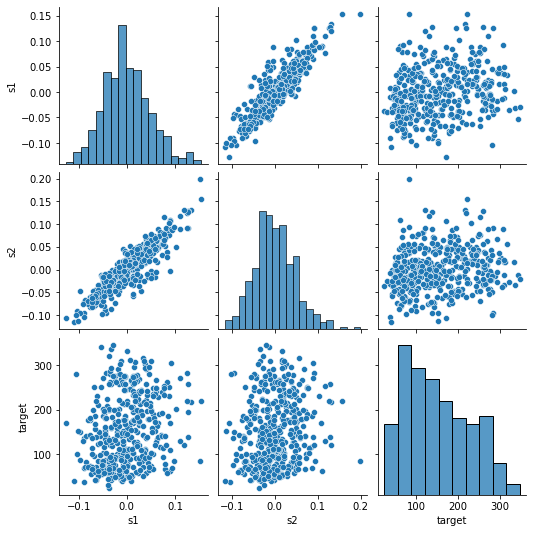

In [127]:
sns.pairplot(pd.concat([X_diabetes[['s1','s2']], y_diabetes], axis=1))

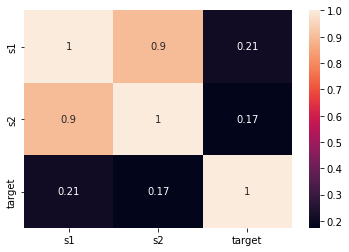

In [189]:
sns.heatmap(pd.concat([X_diabetes[['s1','s2']], y_diabetes], axis=1).corr(), annot=True);

#### Из графиков видно, что имеется сильная свзяь между признаками $s1$ и $s2$ 
- s1      tc, total serum cholesterol
- s2      ldl, low-density lipoproteins

По всей видимости это связано с тем, что один из них вычисляется из другого, поэтому я оставлю только один из них, который сильнее кореллирует с целевой переменной (__s1__)

_цитата из wiki:_

Chemical measures of lipid concentration have long been the most-used clinical measurement, not because they have the best correlation with individual outcome, but because these lab methods are less expensive and more widely available.

The lipid profile does not measure LDL particles. It only estimates them using the Friedewald equation by subtracting the amount of cholesterol associated with other particles, such as HDL and VLDL, assuming a prolonged fasting state, etc.:

$L =~ C-H-kT$<br>
where H is HDL cholesterol, L is LDL cholesterol, C is total cholesterol, T are triglycerides, and k is 0.20 if the quantities are measured in mg/dl and 0.45 if in mmol/l.
There are limitations to this method, most notably that samples must be obtained after a 12 to 14 h fast and that LDL-C cannot be calculated if plasma triglyceride is >4.52 mmol/L (400 mg/dL). Even at triglyceride levels 2.5 to 4.5 mmol/L, this formula is considered inaccurate. If both total cholesterol and triglyceride levels are elevated then a modified formula, with quantities in mg/dl, may be used

$L=C-H-0.16T$<br>
This formula provides an approximation with fair accuracy for most people, assuming the blood was drawn after fasting for about 14 hours or longer, but does not reveal the actual LDL particle concentration because the percentage of fat molecules within the LDL particles which are cholesterol varies, as much as 8:1 variation.

__Также у нас имеется бинарный признак `sex`, и комбинировать его с другими признаками (получать полиномиальные признаки) мне видится бессмысленным, так что, я оставлю этот признак как есть и не буду его преобразовывать__

Как было указано в начале задания, при использовании PolynomialFeatures высоких степеней, может получиться настолько много признаков, что это будет слишком вычислительно трудная задача<br>
Число признаков, при использовании PolynomialFeatures равно $\binom{n_{features}+degree_{poly}}{degree_{poly}}$

In [21]:
import math

In [22]:
def number_of_poly_features(features, degree):
    return math.comb(features + degree, degree)

In [23]:
X_diabetes.columns.size

10

### Если мы не будем использовать  признаки `sex` и `s2` для построения полиномиальных признаков, то у нас останется 8 признаков, посмотрим как будет расти число признаков с ростом степени полинома

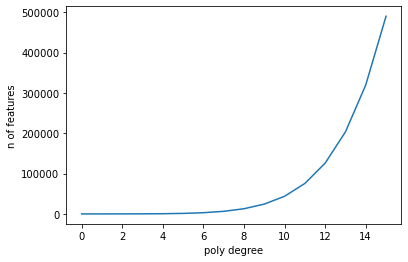

In [24]:
plt.plot(np.arange(0,16),
         list(map(lambda deg: number_of_poly_features(8, deg), range(16))),
         
        );
plt.ylabel('n of features');
plt.xlabel('poly degree');

In [239]:
X_diabetes['age'].nbytes

3536

### учитывая, что один признак занимает ~3.5kB, а для обращения матрицы $X^TX$ нужно $\approx{O(N^3)}$ операций, понятно, что вычислительно (и по потреблению памяти) задача и правда может оказаться слишком большой для моего компьютера

ColumnTransformer поможет удобно преобразовывать только выбранные признаки, а остальные не трогать(`passthrough`) или отбрасывать(`drop`)

In [25]:
from sklearn.compose import ColumnTransformer

In [26]:
col_trf = ColumnTransformer(transformers=[('poly',PolynomialFeatures(include_bias=False),
                                           ('bmi','bp','s1','s3','s5', 's6')),
                                          ('s2', 'drop', ['s2'])
                                         ],
                            remainder='passthrough',verbose_feature_names_out=False)

In [27]:
pd.DataFrame(col_trf.set_params(poly__degree=2).fit_transform(X_diabetes.head()), columns=col_trf.get_feature_names_out())

,bmi,bp,s1,s3,s5,s6,bmi^2,bmi bp,bmi s1,bmi s3,...,s1 s6,s3^2,s3 s5,s3 s6,s5^2,s5 s6,s6^2,age,sex,s4
0,0.061696,0.021872,-0.044223,-0.043401,0.019908,-0.017646,0.003806,0.001349,-0.002728,-0.002678,...,0.000780,0.001884,-0.000864,0.000766,0.000396,-0.000351,0.000311,0.038076,0.050680,-0.002592
1,-0.051474,-0.026328,-0.008449,0.074412,-0.068330,-0.092204,0.002650,0.001355,0.000435,-0.003830,...,0.000779,0.005537,-0.005085,-0.006861,0.004669,0.006300,0.008502,-0.001882,-0.044642,-0.039493
2,0.044451,-0.005671,-0.045599,-0.032356,0.002864,-0.025930,0.001976,-0.000252,-0.002027,-0.001438,...,0.001182,0.001047,-0.000093,0.000839,0.000008,-0.000074,0.000672,0.085299,0.050680,-0.002592
3,-0.011595,-0.036656,0.012191,-0.036038,0.022692,-0.009362,0.000134,0.000425,-0.000141,0.000418,...,-0.000114,0.001299,-0.000818,0.000337,0.000515,-0.000212,0.000088,-0.089063,-0.044642,0.034309
4,-0.036385,0.021872,0.003935,0.008142,-0.031991,-0.046641,0.001324,-0.000796,-0.000143,-0.000296,...,-0.000184,0.000066,-0.000260,-0.000380,0.001023,0.001492,0.002175,0.005383,-0.044642,-0.002592


Создадим новый `pipeline` 

In [28]:
def make_model_new(degree, alpha=0, penalty=None, poly_features=['bmi','bp','s1','s3','s4']):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=500000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=500000) 
    
    
    return Pipeline([
        ('pol', ColumnTransformer(transformers=[('poly',
                                                 PolynomialFeatures(degree, include_bias=False),
                                                 poly_features),
                                                ('s2', 'drop', ['s2'])
                                               ],
                                  remainder='passthrough',
                                  verbose_feature_names_out=False)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

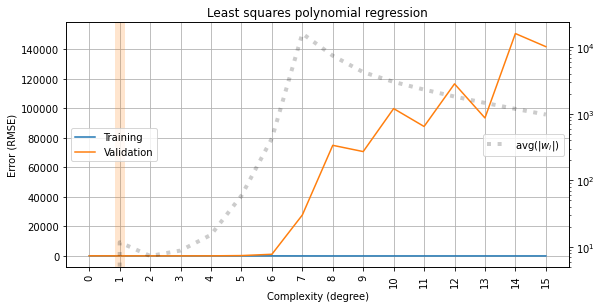

In [234]:
rmse_train, rmse_valid, avg_coef = [], [], []
# случай 0 степени пришлось рассмотреть отдельно
zero_deg = cross_validate(make_model_new(0)[1:],
                             np.ones_like(y_diabetes), y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
rmse_train.append(-np.mean(zero_deg['train_score']))
rmse_valid.append(-np.mean(zero_deg['test_score']))
avg_coef.append(0)
for degree in DEGREES[1:]:
    results = cross_validate(make_model_new(degree, poly_features=['bmi', 's1', 's3', 's5']),
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, 
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_)) for model in results['estimator']
        ]))

plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

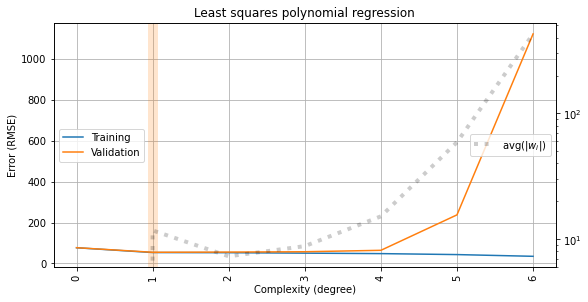

In [235]:
plot_fitting_graph(DEGREES[:7], rmse_train[:7], rmse_valid[:7],
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef[:7], custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

# your findings/conclusions
Уже с 5 степени полиномиальных признаков начинается сильное переобучение, это видно по сильной разнице в метрике RMSE на тестовой выборке и на тренировочной, то что ошибка на тренировочной выборке продолжает убывать, а на тестовой наблюдается взрывной рост, как раз говорит нам о высоком bias модели — модель переобучается.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [33]:
def l2_norm(weights):
    return np.sqrt(np.sum(weights**2))

In [226]:
## your code
rmse_train, rmse_valid, l2_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_new(degree=7, penalty='L1', alpha=alpha, poly_features=['bmi', 's3', 's5']), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    l2_coef.append(
        # average over CV folds
        np.mean([            
            # L2 norm of weights
            l2_norm(e['reg'].coef_) for e in results['estimator']
        ]))

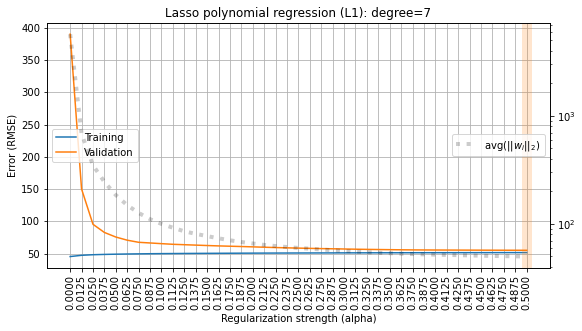

In [227]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l2_coef, custom_label='avg($||w_i||_2$)',
                   title='Lasso polynomial regression (L1): degree=7')

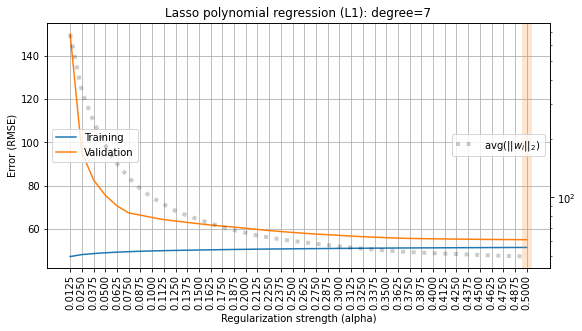

In [228]:
plot_fitting_graph(ALPHAS[1:], rmse_train[1:], rmse_valid[1:],
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l2_coef[1:], custom_label='avg($||w_i||_2$)',
                   title='Lasso polynomial regression (L1): degree=7')

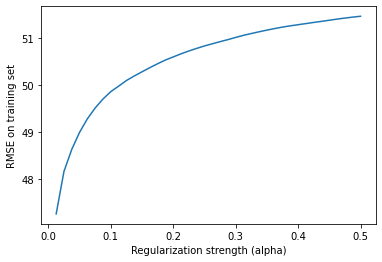

In [229]:
plt.plot(ALPHAS[1:], rmse_train[1:])
plt.xlabel('Regularization strength (alpha)');
plt.ylabel('RMSE on training set');

#### L2

In [230]:
rmse_train, rmse_valid, l2_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_new(degree=7, penalty='L2', alpha=alpha, poly_features=['bmi', 's3', 's5']), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    l2_coef.append(
        # average over CV folds
        np.mean([            
            # L2 norm of weights
            l2_norm(e['reg'].coef_) for e in results['estimator']
        ]))

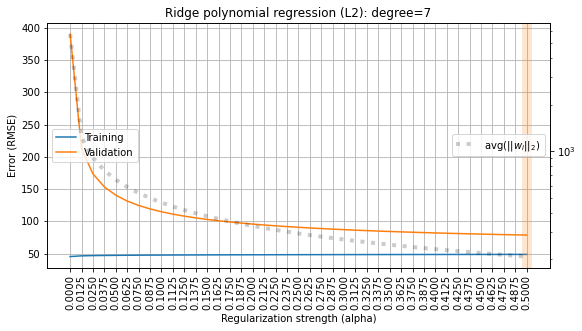

In [231]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l2_coef, custom_label='avg($||w_i||_2$)',
                   title='Ridge polynomial regression (L2): degree=7')

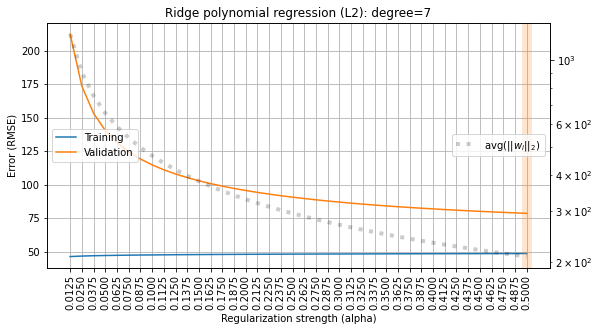

In [232]:
plot_fitting_graph(ALPHAS[1:], rmse_train[1:], rmse_valid[1:],
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l2_coef[1:], custom_label='avg($||w_i||_2$)',
                   title='Ridge polynomial regression (L2): degree=7')

In [220]:
rmse_train, rmse_valid, l2_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_new(degree=15, penalty='L2', alpha=alpha, poly_features=['bmi', 's3', 's5']), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    l2_coef.append(
        # average over CV folds
        np.mean([            
            # L2 norm of weights
            l2_norm(e['reg'].coef_) for e in results['estimator']
        ]))

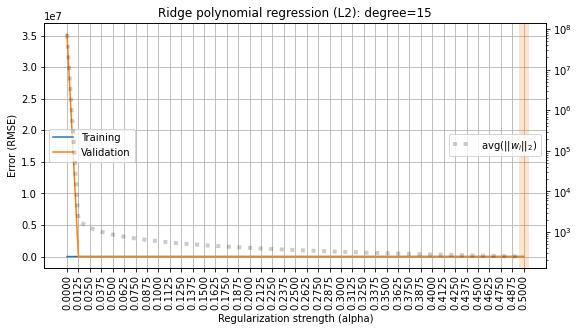

In [221]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l2_coef, custom_label='avg($||w_i||_2$)',
                   title='Ridge polynomial regression (L2): degree=15')

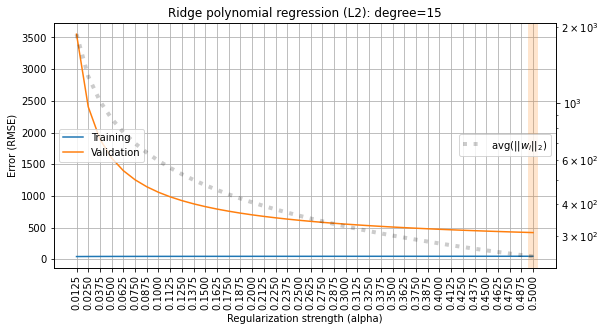

In [222]:
plot_fitting_graph(ALPHAS[1:], rmse_train[1:], rmse_valid[1:],
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l2_coef[1:], custom_label='avg($||w_i||_2$)',
                   title='Ridge polynomial regression (L2): degree=15')

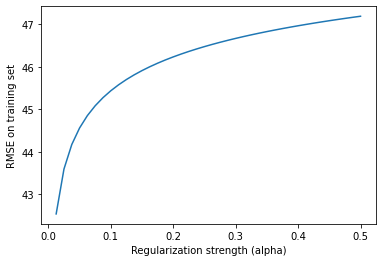

In [223]:
plt.plot(ALPHAS[1:], rmse_train[1:])
plt.xlabel('Regularization strength (alpha)');
plt.ylabel('RMSE on training set');

#### Summary

## your observations/conclusions
Оба метода регуляризации улучшали поведение модели на тестовых выборках.<br>
С ростом параметра регуляризации монотонно уменьшается RMSE на тестовых выборках, и наоборот увеличивается ошибка на обучающей, что свидетельствует об уменьшении переобучения модели.<br>
Также на графиках видно, что с ростом параметра регуляризации, уменьшается $L_2-norm$ весов, что также свидетельсвует об уменьшении переобучения и уменьшении влияния признаков высоких степеней(задавливаем большие коэффициенты).<br>

Отдельно нужно сказать о различии в L2-регуляризации и L1-регуляризации.<br>
По графикам видно, что при L1-регуляризации достигаем гораздо меньших(различие на порядок) значений ошибок на тест. выборке, чем при L2-рег, однако сходимость метода L1 гораздо хуже, чем L2 (мне пришлось поднять число итераций в 10 раз, и уменьшить степень полиномиальных признаков до 9-степени, чтобы добиться адекватного времени исполнения, при этом L2-рег. сходится гораздо лучше даже на 15 степени(сделал отдельно), но ошибки больше)

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [80]:
## your code
reg_coefs_L1 = []
for alpha in ALPHAS:    
    results = cross_validate(make_model_new(degree=7, penalty='L1', alpha=alpha, poly_features=['bmi', 's3', 's5']), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    reg_coefs_L1.append(np.array([e['reg'].coef_ for e in results['estimator']]).mean(axis=0))

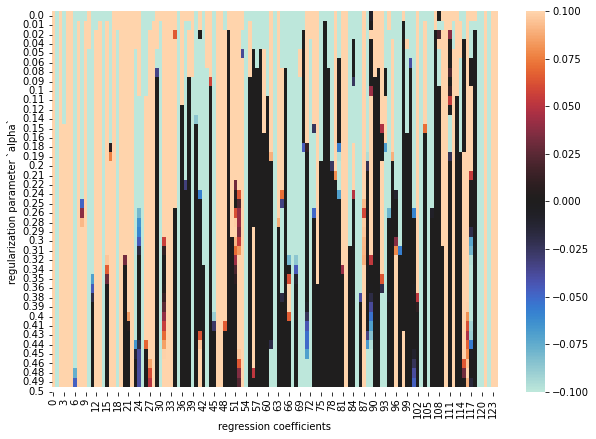

In [95]:
plt.figure(figsize=(10,7));
sns.heatmap(np.array(reg_coefs_L1[1:]),vmin=-0.1,vmax=0.1, center=0, yticklabels=ALPHAS.round(2))
plt.ylabel('regularization parameter `alpha`');
plt.xlabel('regression coefficients');

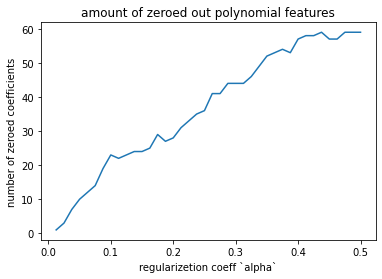

In [105]:
plt.plot(ALPHAS[1:],(np.array(reg_coefs_L1[1:])==0).sum(axis=1))
plt.ylabel('number of zeroed coefficients');
plt.xlabel('regularizetion coeff `alpha`')
plt.title('amount of zeroed out polynomial features');

#### L2

In [123]:
## your code
## your code
reg_coefs_L2 = []
for alpha in ALPHAS:    
    results = cross_validate(make_model_new(degree=7, penalty='L2', alpha=alpha, poly_features=['bmi', 's3', 's5']), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    reg_coefs_L2.append(np.array([e['reg'].coef_ for e in results['estimator']])[0].mean(axis=0))

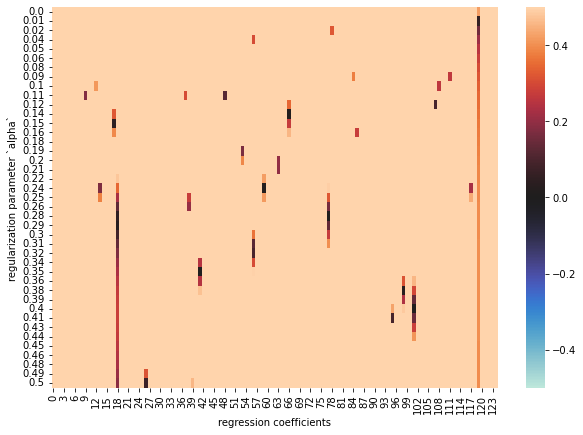

In [153]:
plt.figure(figsize=(10,7));
sns.heatmap(abs(np.array(reg_coefs_L2)), vmin=-0.5, vmax=0.5, center=0, yticklabels=ALPHAS.round(2))
plt.ylabel('regularization parameter `alpha`');
plt.xlabel('regression coefficients');

In [173]:
np.array(reg_coefs_L2)[np.isclose(np.array(reg_coefs_L2), np.zeros_like(reg_coefs_L2), rtol=1e-1, atol=1e-1)]

array([ 0.05600766,  0.09497106,  0.01329259,  0.04598376,  0.01873766,
       -0.04762428, -0.01088255,  0.02378297,  0.08389927, -0.0960536 ,
       -0.00626936,  0.02838973, -0.00806431,  0.09112245, -0.07157224])

список близких к 0 коэффициентов среди различных значений к-та регуляризации (видно, что ни одного нулевого нет)

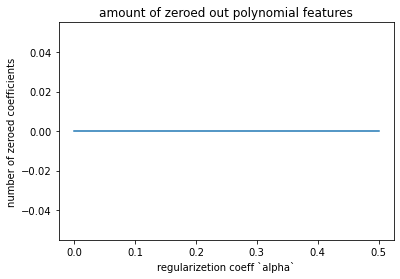

In [129]:
plt.plot(ALPHAS,(np.array(reg_coefs_L2)==0).sum(axis=1))
plt.ylabel('number of zeroed coefficients');
plt.xlabel('regularizetion coeff `alpha`')
plt.title('amount of zeroed out polynomial features');

#### Summary

# your findings/conclusions
В случае L2-регуляризации, коэффициенты асимптотически стремятся к 0, то есть в случае L2-рег мы стремясь минимизировать L2-норму коэффициентов (большие коэффициенты вносят больший вклад в значение L2-нормы, соответственно при минимизации, этот метод задавливает значения самых больших коэффициентов, но никогда не обращает их в ноль), в отличие от L1-регуляризации, в виду особенности регуляризационного члена, коэффициенты действительно могут принять значения равные нулю, что и позволяет использовать этот метод регуляризации, для отбора признаков

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [174]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


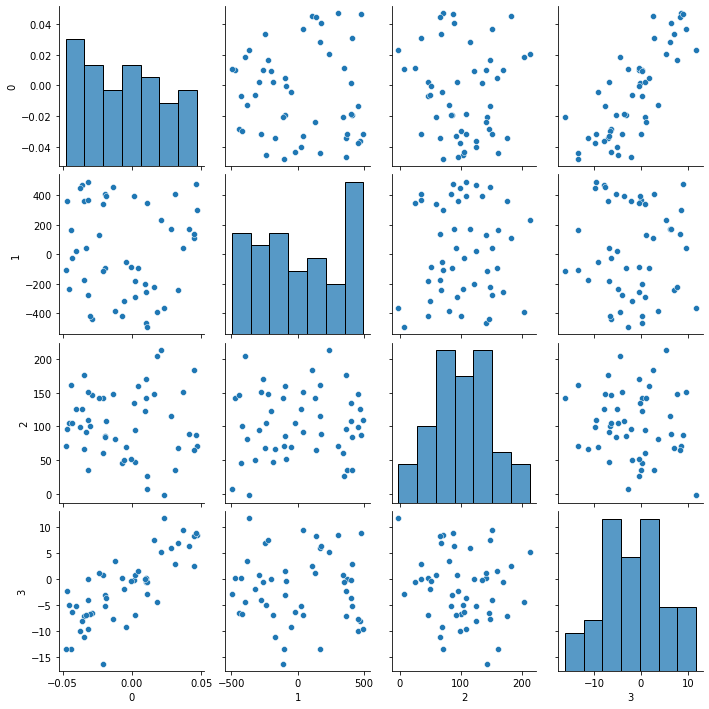

In [184]:
sns.pairplot(pd.DataFrame(np.column_stack((X_hw,y_hw))))

#### L1

In [192]:
def make_model_has_scaler(degree, alpha=0, penalty=None, scaler=True):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=False)),
        ('sca', StandardScaler() if scaler else 'passthrough'),
        ('reg', regressor)
    ])

In [199]:
## your code
rmse_train, rmse_valid, l2_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_has_scaler(degree=3, alpha=alpha, penalty='L1', scaler=False), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    l2_coef.append(
        # average over CV folds
        np.mean([            
            # L2 norm of weights
            l2_norm(e['reg'].coef_) for e in results['estimator']
        ]))

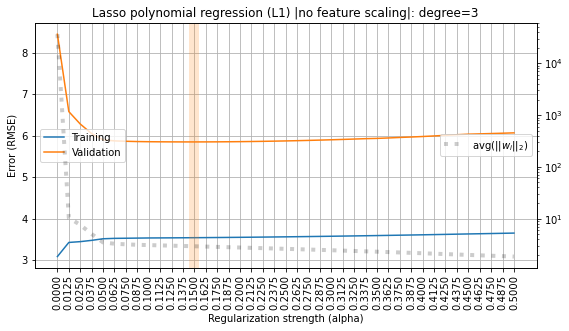

In [200]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l2_coef, custom_label='avg($||w_i||_2$)',
                   title='Lasso polynomial regression (L1) |no feature scaling|: degree=3')

In [196]:
## your code
rmse_train, rmse_valid, l2_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_has_scaler(degree=3, alpha=alpha, penalty='L1', scaler=True), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    l2_coef.append(
        # average over CV folds
        np.mean([            
            # L2 norm of weights
            l2_norm(e['reg'].coef_) for e in results['estimator']
        ]))

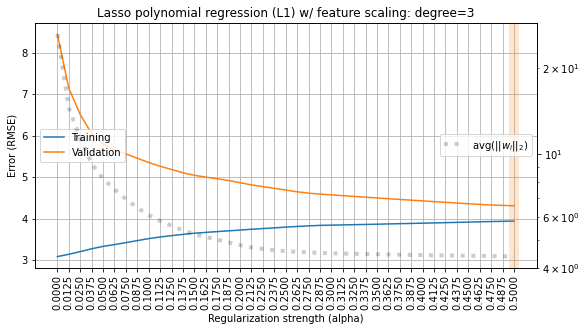

In [198]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l2_coef, custom_label='avg($||w_i||_2$)',
                   title='Lasso polynomial regression (L1) w/ feature scaling: degree=3')

#### L2

In [207]:
## your code
## your code
rmse_train, rmse_valid, l2_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_has_scaler(degree=2, alpha=alpha, penalty='L2', scaler=False), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    l2_coef.append(
        # average over CV folds
        np.mean([            
            # L2 norm of weights
            l2_norm(e['reg'].coef_) for e in results['estimator']
        ]))

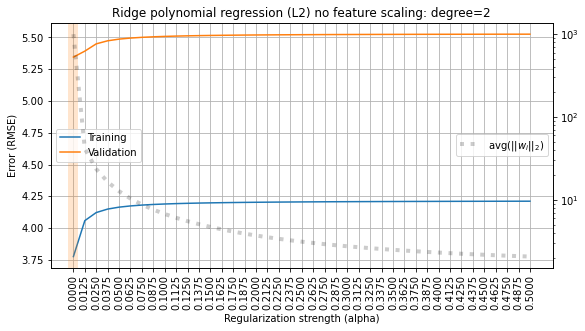

In [209]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l2_coef, custom_label='avg($||w_i||_2$)',
                   title='Ridge polynomial regression (L2) no feature scaling: degree=2')

In [215]:
## your code
## your code
rmse_train, rmse_valid, l2_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_has_scaler(degree=2, alpha=alpha, penalty='L2', scaler=True), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    l2_coef.append(
        # average over CV folds
        np.mean([            
            # L2 norm of weights
            l2_norm(e['reg'].coef_) for e in results['estimator']
        ]))

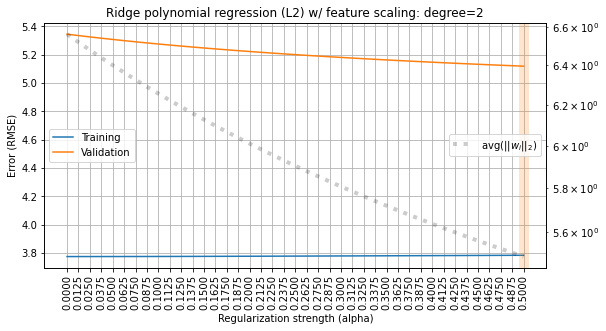

In [216]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=l2_coef, custom_label='avg($||w_i||_2$)',
                   title='Ridge polynomial regression (L2) w/ feature scaling: degree=2')

#### Summary



## your observations/conclusions
При использовании полиномиальных признаков, если мы не масштабируем признаковые переменные, то у нас в степенных признаках могут попадаться сколь угодно большие значения, что приведет к плохообусловленной матрице, что в свою очередь затруднит или же вообще не позволит нам найти для неё обратную(необходимо при решении нормальных уравнений линейной регрессии) и будут ухудшать(или же вообще приводить к расхождению) сходимость итерационных процессов<br>
Ещё пара эмпирических наблюдений, что L1-регуляризация, что L2-регуляризация используют итерационный подход.<br> 
Так вот в случае L1, если не масштабировать признаки, ухудшается сходимость(просто заметно дольше считается даже для признаков 3 степени), к тому же по графикам видно, что качество модели тоже страдает(ошибки значительно выше), по сравнению с масштабированными признаками.<br> 
В случае L2-регуляризации, без масштабирования признаков, при степенях выше 2 как раз таки появляется плохообусловленная матрица, о чем SciKit-learn предупреждает __/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.86305e-19): result may not be accurate__<br>
На графиках видно, что при масштабирования, при L2-регуляризации, качество модели улучшается ЗНАЧИТЕЛЬНО(на 3 порядка), а также улучшается сходимость и обусловленность матриц<br>
Также по графикам видно, что в обоих случаях L2-норма весов _больше_ в случаях без масштабирования призаков